In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATAPATH = "data/"

In [3]:
dataset = pd.read_csv(DATAPATH+"cleaned_data_train.csv", names="user_id,movie_id,prediction".split(','))
dataset['user_id'] = dataset['user_id']-1
dataset['movie_id'] = dataset['movie_id']-1
dataset.head()

,user_id,movie_id,prediction
0,43,0,4
1,60,0,3
2,66,0,4
3,71,0,3
4,85,0,5


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.1)

In [5]:
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.movie_id.unique())
n_latent_factors = 3

In [7]:
from keras.constraints import non_neg

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         3003        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         30003       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [9]:
history = model.fit([train.user_id, train.movie_id], train.prediction, epochs=40, verbose=1)

Epoch 1/40
1059256/1059256 [==============================] - 31s 30us/step - loss: 3.7683
Epoch 2/40
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.0443
Epoch 3/40
1059256/1059256 [==============================] - 31s 29us/step - loss: 1.0385
Epoch 4/40
1059256/1059256 [==============================] - 31s 29us/step - loss: 1.0358
Epoch 5/40
1059256/1059256 [==============================] - 31s 29us/step - loss: 1.0335
Epoch 6/40
1059256/1059256 [==============================] - 31s 29us/step - loss: 1.0313
Epoch 7/40
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.0294
Epoch 8/40
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.0273
Epoch 9/40
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.0261
Epoch 10/40
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.0240
Epoch 11/40
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.02

Text(0,0.5,'Train Error')

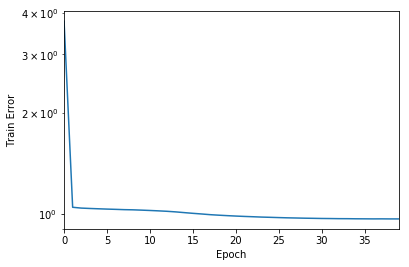

In [10]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [14]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_hat[y_hat < 1] = 1
y_hat[y_hat > 5] = 5
y_true = test.prediction

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_squared_error(y_true, y_hat)

1.0881678221859707

In [13]:
dataset_to_predict = pd.read_csv(DATAPATH+"cleaned_sample.csv", names="user_id,movie_id,prediction".split(','))
dataset_to_predict ['user_id'] = dataset_to_predict ['user_id']-1
dataset_to_predict ['movie_id'] = dataset_to_predict ['movie_id']-1
dataset_to_predict .head()

,user_id,movie_id,prediction
0,36,0,3
1,72,0,3
2,155,0,3
3,159,0,3
4,247,0,3


In [18]:
predictions = np.round(model.predict([dataset_to_predict.user_id, dataset_to_predict.movie_id]),0)
predictions[predictions < 1] = 1
predictions[predictions > 5] = 5

In [19]:
dataset_to_predict["prediction"] = predictions.astype(int)

In [20]:
dataset_to_predict.head()

,user_id,movie_id,prediction
0,36,0,4
1,72,0,3
2,155,0,4
3,159,0,3
4,247,0,4


In [21]:
def create_submission():
    f = open(DATAPATH+"submission2.csv", "w")
    f.write("Id,Prediction\n")
    for _,d in dataset_to_predict.iterrows():
        text = 'r'+str(d[0]+1)+'_c'+str(d[1]+1)+','+str(d[2])+'\n'
        f.write(text)
    f.close()
    
    

In [22]:
create_submission()